<a href="https://colab.research.google.com/github/BuseFidan/buildOpenCV/blob/master/latest_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.utils import np_utils
from keras import metrics
#from sklearn.metrics import confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Reshape, Activation, LSTM

from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tarfile
tar = tarfile.open("/content/drive/MyDrive/RML2016.10a.tar.bz2", "r:bz2")  
tar.extractall()

In [6]:
with open("RML2016.10a_dict.pkl", "rb") as p:
    d = pickle.load(p, encoding='latin1')

In [13]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

modulation_types = []    
for i in d.keys():    
    if i[0] not in modulation_types:
        modulation_types.append(i[0])


values = array(modulation_types)
print("values: ",values)
label_encoder = LabelEncoder().fit(values)
integer_encoded = LabelEncoder().fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

values:  ['QPSK' 'PAM4' 'AM-DSB' 'GFSK' 'QAM64' 'AM-SSB' '8PSK' 'QAM16' 'WBFM'
 'CPFSK' 'BPSK']
[ 9  6  1  5  8  2  0  7 10  4  3]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
['QPSK']


In [14]:
SNRs = {}
for key in d.keys():
    if key not in SNRs:
        SNRs[key[1]] = []

for keys in d.keys():
    for arrays in d[keys]:
        # convert labels to one-hot encoders.
        index = values.tolist().index(keys[0])
        SNRs[keys[1]].append([onehot_encoded[index, :],np.array(arrays)]) 

In [58]:
import itertools
new_data = []
for key in SNRs.keys():   
    new_data.append(SNRs[key][:])

new_data = list(itertools.chain.from_iterable(new_data))

dataset = []
labels = []

for values in new_data:
    labels.append(values[0])
    dataset.append(values[1])

#dataset = np.vstack(dataset)
label = np.array(labels)
dataset = np.array(dataset)
label.shape
dataset.shape

(220000, 2, 128)

In [44]:
inputs = []  #2d
outputs = []  #1d
for mod in modulation_types:
    for snr in SNRs:
        inputs.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  
            outputs.append(mod)

inputs = np.vstack(inputs)
data[(mod,snr)].shape[0]
type(inputs)

output = np.array(outputs)
output.shape
inputs.shape


(220000, 2, 128)

In [ ]:
moduls = np.array(modulation_types).reshape(len(modulation_types),1)    # 485ms
enc = OneHotEncoder()
enc.fit(moduls)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [62]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.33, random_state = 42)
X_train, x_val, Y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

#Y_train = np.array(Y_train).reshape(len(Y_train), 1)
#y_test = np.array(y_test).reshape(len(y_test), 1)

print(y_test)

x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
#y_val = np.array(y_val).reshape(len(y_val), 1)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]]


In [23]:
input_shape = (2,128,1)

In [63]:
    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_uniform', input_shape = input_shape))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid',  data_format=None))
    model.add(keras.layers.Dropout(.5))
    
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(keras.layers.Dropout(.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(keras.layers.Dropout(.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(1, 2), padding='valid', data_format=None))
    model.add(keras.layers.Dropout(.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(11, activation='softmax', kernel_initializer='he_normal'))
    model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 2, 128, 256)       2560      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 64, 256)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 64, 256)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 64, 128)        295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 32, 128)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2, 32, 128)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 2, 32, 64)        

In [64]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X_train, Y_train, validation_data = (x_val, y_val), callbacks = callbacks, epochs=5, batch_size = 200)

Epoch 1/5
590/590 [==============================] - 59s 49ms/step - loss: 2.2054 - accuracy: 0.1747 - val_loss: 2.0649 - val_accuracy: 0.2351
Epoch 2/5
590/590 [==============================] - 28s 48ms/step - loss: 1.9640 - accuracy: 0.2651 - val_loss: 1.8637 - val_accuracy: 0.3013
Epoch 3/5
590/590 [==============================] - 28s 48ms/step - loss: 1.8365 - accuracy: 0.3040 - val_loss: 1.7789 - val_accuracy: 0.3239
Epoch 4/5
590/590 [==============================] - 28s 48ms/step - loss: 1.7819 - accuracy: 0.3242 - val_loss: 1.7451 - val_accuracy: 0.3393
Epoch 5/5
590/590 [==============================] - 28s 48ms/step - loss: 1.7430 - accuracy: 0.3409 - val_loss: 1.7082 - val_accuracy: 0.3659


In [ ]:
score = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

RuntimeError: ignored

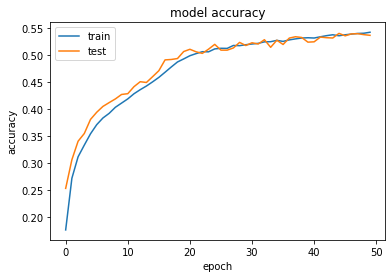

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

No handles with labels found to put in legend.


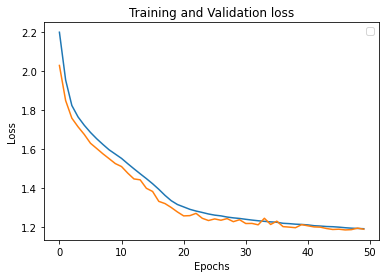

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

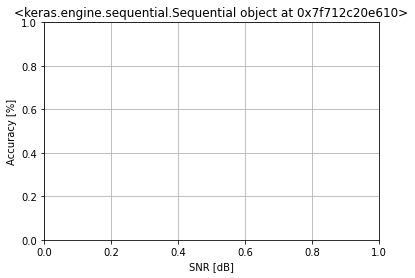

In [ ]:
plt.title(model)
plt.xlabel('SNR [dB]')
plt.ylabel('Accuracy [%]')
plt.grid()
plt.show()

In [ ]:
def sorter(dataset1, legend1 = None, model = ''):
 
    y = []
    x = []

    for i in range(len(dataset1)):
        x.append(dataset1[i][1])
    x = sorted(x)


    for i in x:
        for j in range(len(dataset1)):
            if dataset1[j][1]  == i:
                y.append(dataset1[j][0])
        
    fig = plt.figure(figsize = (10,8))
    plt.plot(x,y, linestyle = '--', marker = 'o', label = legend1)
   
    plt.title(model)
    plt.xlabel('SNR [dB]')
    plt.ylabel('Accuracy [%]')
    plt.grid()
    plt.show()

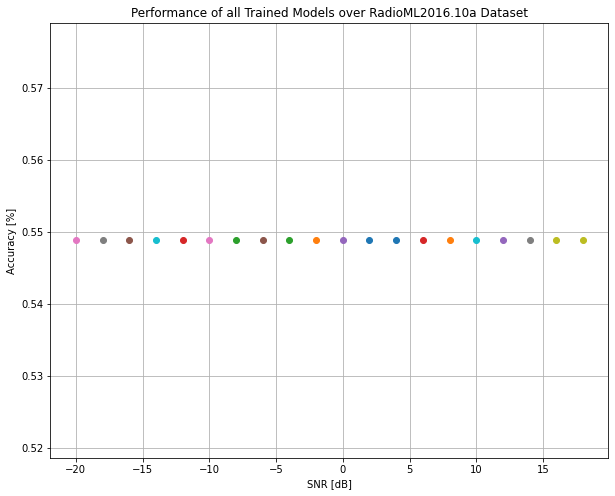

In [ ]:
sorter(accuracies_All, 'fcxgf', model = 'Performance of all Trained Models over RadioML2016.10a Dataset')